In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dbslim_descriptors']


In [2]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
import pickle
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input
from keras.models import Sequential, Model
from keras import optimizers, regularizers, initializers
from keras.callbacks import ModelCheckpoint, Callback
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
NCA1 = 50
NCA2 = 50
DROPRATE = 0.2
EP = 500
BATCH_SIZE = 256
VAL_RATIO = 0.1
TEST_RATIO = 0.1

## Loading Drugbank dataset

In [4]:
db_therapeutic_df= pd.read_csv('../input/dbslim_descriptors/db_theraputic_df.csv')
print(db_therapeutic_df.shape)
db_therapeutic_df.head()

(1242, 48)


,Unnamed: 0,type,drugbank_id,name,description,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,half-life,protein-binding,route-of-elimination,clearance,groups,targets,enzymes,atc_codes,categories,inchi,inchikey,SMILES,logS,logP,Water_Solubility,Melting_Point,Boiling_Point,Hydrophobicity,Isoelectric_Point,caco2_Permeability,pKa,Radioactivity,aliases,smiles,inhibitor,blocker,agonist,antagonist,analgesic,antibiotic,anticoagulant,antidepressant,anticancer,antiepileptic,antipsychotic,antiviral,sedative,antidiabetic
0,0,small molecule,DB00006,Bivalirudin,Bivalirudin is a synthetic 20 residue peptide ...,Bivalirudin directly and reversibly inhibits t...,Inhibits the action of thrombin by binding bot...,"Based on a study by Gleason et al., the no-obs...",80% proteolytic cleavage,"Following intravenous administration, bivaliru...",* Normal renal function: 25 min (in normal con...,"Other than thrombin and red blood cells, bival...",Bivalirudin is cleared from plasma by a combin...,* 3.4 mL/min/kg [Normal renal function]\r\r\n*...,approved|investigational,\r\n,\r\n,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,OIRCOABEOLEUMC-GEJPAHFPSA-N,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\r\n |Angiomax|Bivalirudin|Bivalirudin fo...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,small molecule,DB00014,Goserelin,"Goserelin is a synthetic hormone. In men, it s...",The pharmacokinetics of goserelin have been de...,Goserelin is a synthetic decapeptide analogue ...,No experience of overdosage from clinical trials.,Hepatic,"Inactive orally, rapidly absorbed following su...",4-5 hours,27.3%,Clearance of goserelin following subcutaneous ...,* 121 +/- 42.4 mL/min [prostate cancer with 10...,approved,\r\n |\r\n,NaN,L02AE03,"Adrenal Cortex Hormones|Amino Acids, Peptides,...",InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,BLCLNMBMMGCOAS-URPVMXJPSA-N,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\r\n |Goserelin|Zoladex|Zoladex LA,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,small molecule,DB00035,Desmopressin,"Desmopressin (dDAVP), a synthetic analogue of ...","By mimicking the actions of endogenous ADH, de...",Upon binding of desmopressin to V2 receptors i...,Intravenous TDLo in humans is reported to be 0...,"In vitro, in human liver microsome preparation...",Following nasal spray administration of 0.83 m...,Following an intranasal dose of 1.66 mcg of de...,Following radioiodination (125I) in the N-term...,Desmopressin is mainly excreted in the urine. ...,NaN,approved,\r\n |\r\n |\r\n,\r\n |\r\n,H01BA02,"Agents that produce hypertension|Amino Acids, ...",InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,NFLWUMRGJYTJIN-NXBWRCJVSA-N,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\r\n |DDAVP Rhinal Tube|Ddavp|Ddavp Inj 4...,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,small molecule,DB00050,Cetrorelix,Cetrorelix is a man-made hormone that blocks t...,Cetrorelix is a synthetic decapeptide with gon...,Cetrorelix binds to the gonadotropin releasing...,NaN,"In in vitro studies, cetrorelix was stable aga...",Rapidly absorbed following subcutaneous inject...,~62.8 hours,86%,Following subcutaneous administration of 10 mg...,* 1.28 ml/min·kg [adult healthy female with 3 ...,approved|investigational,\r\n |\r\n,NaN,H01CC02,"Amino Acids, Peptides, and Proteins|Anti-Gonad...",InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,SBNPWPIBESPSIF-MHWMIDJBSA-N,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cetrorelix|Cetrotide,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,

In [5]:
db_therapeutic_df.columns

Index(['Unnamed: 0', 'type', 'drugbank_id', 'name', 'description',
       'pharmacodynamics', 'mechanism-of-action', 'toxicity', 'metabolism',
       'absorption', 'half-life', 'protein-binding', 'route-of-elimination',
       'clearance', 'groups', 'targets', 'enzymes', 'atc_codes', 'categories',
       'inchi', 'inchikey', 'SMILES', 'logS', 'logP', 'Water_Solubility',
       'Melting_Point', 'Boiling_Point', 'Hydrophobicity', 'Isoelectric_Point',
       'caco2_Permeability', 'pKa', 'Radioactivity', 'aliases', 'smiles',
       'inhibitor', 'blocker', 'agonist', 'antagonist', 'analgesic',
       'antibiotic', 'anticoagulant', 'antidepressant', 'anticancer',
       'antiepileptic', 'antipsychotic', 'antiviral', 'sedative',
       'antidiabetic'],
      dtype='object')

In [6]:
db_therapeutic_df['anticoagulant'].value_counts()

0.0    1231
1.0      11
Name: anticoagulant, dtype: int64

In [7]:
db_therapeutic_df.drop(['Unnamed: 0', 'type', 'drugbank_id', 'name', 'description',
                        'pharmacodynamics', 'mechanism-of-action', 'toxicity', 'metabolism',
                        'absorption', 'half-life', 'protein-binding', 'route-of-elimination',
                        'clearance', 'groups', 'targets', 'enzymes', 'atc_codes', 'categories',
                        'inchi', 'inchikey', 'SMILES', 'logS', 'logP', 'Water_Solubility',
                        'Melting_Point', 'Boiling_Point', 'Hydrophobicity', 'Isoelectric_Point',
                        'caco2_Permeability', 'pKa', 'Radioactivity', 'aliases', 'smiles',
                        'anticancer','antidiabetic','antiepileptic'], axis=1, inplace=True)
print(db_therapeutic_df.shape)
db_therapeutic_df.head()

(1242, 11)


,inhibitor,blocker,agonist,antagonist,analgesic,antibiotic,anticoagulant,antidepressant,antipsychotic,antiviral,sedative
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Loading molecular descriptors

Descriptors dataframe contains 1625 molecular descriptors (including 3D descriptors) generated on the NCI database using Mordred python module.

Further Reading:
* https://en.wikipedia.org/wiki/Molecular_descriptor
* https://github.com/mordred-descriptor/mordred

In [8]:
db_therapeutic_descriptors_df= pd.read_csv('../input/dbslim_descriptors/dbslim_descriptors_df.csv',low_memory=False)
print(db_therapeutic_descriptors_df.shape)
db_therapeutic_descriptors_df.head()

(1242, 1825)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,116.622994,86.472639,6,4,190.059247471018,2.4273622051919244,4.802288542980252,190.059247471018,1.2261886933614066,5.92244693911214,5.12936181501278,0.033092656871050195,4.37582127283762,42672119.82684092,275303.99888284464,20.309896357415763,18,18,293,155,0,0,57,138,0,98,24,33,0,0,0,0,0,0,0,2408.000000,2042.000000,2714.000000,2896.000000,3425.000000,...,0.015002,0.010067,0.007966,0.008238,0.484420,65,33,0.969697,0.492308,2055.8114788250696,8.321928094887362,160.0,6.624065,7.434257,8.289791,9.124674,9.982160,10.829352,11.689673,12.544276,13.407430,404.925677,5.771441,0.0,7.077498,3.433987,8.534050,5.686975,10.063947,7.703008,11.639214,214.910121,2178.985813,7.436812,286334,230,752.0,846.0,62.41666666666667,34.777778
1,69.692912,55.004022,0,3,113.15528560572784,2.422175716305222,4.78275049155413,113.15528560572784,1.2434646769860203,5.408857639964532,5.13224042708964,0.0563982464515345,3.843816707793337,16685.312875051288,183.35508653902514,11.930558556408478,20,21,175,91,0,0,32,84,0,59,18,14,0,0,0,0,0,0,0,1330.000000,1210.000000,1625.000000,1705.000000,1973.000000,...,0.015106,0.009769,0.008653,0.007899,0.482487,32,16,1.000000,0.500000,1176.9200636461194,7.584962500721156,96.0,6.129050,6.951772,7.820440,8.665096,9.534378,10.389826,11.260417,12.122175,12.994105,272.867259,5.262690,0.0,6.586172,3.713572,8.061171,5.973810,9.608109,7.965893,11.198119,149.369536,1268.641439,7.249380,52357,134,458.0,522.0,34.28472222222223,20.069444
2,77.541280,58.264383,0,3,126.89538756078316,2.4115308512974982,4.787916364949785,126.89538756078316,1.2440724270665016,5.515080865340357,4.795238238236601,0.047012139590554905,3.890011112112258,45083.82639072676,441.99829794830157,13.038666564849082,28,29,194,102,0,0,32,92,0,70,17,14,0,0,0,1,0,0,1,1421.604938,1295.111111,1714.666667,1840.666667,2060.111111,...,0.015050,0.009173,0.008227,0.007471,0.462562,36,18,1.000000,0.500000,1344.6714548542852,7.741466986401147,107.0,6.224558,7.041412,7.898411,8.737292,9.596079,10.445957,11.307045,12.163264,13.026476,295.440494,5.370638,0.0,6.678342,2.397895,8.147578,4.595120,9.692952,6.605298,11.281813,156.769635,1429.669818,7.369432,72418,154,504.0,571.0,38.16666666666668,22.777778
3,85.923422,63.492873,4,1,139.37822670089346,2.418458544533781,4.792781681320365,139.37822670089346,1.2119845800077693,5.6207960906392715,4.529583822034547,0.03938768540899606,3.952977099128148,121915.35121688285,1060.1334888424594,14.153429275779933,15,16,216,115,0,0,43,101,0,72,17,26,0,0,0,0,0,0,0,1818.000000,1535.000000,2062.000000,2309.000000,2873.000000,...,0.015040,0.010710,0.008014,0.007956,0.494456,38,19,1.000000,0.500000,1516.0479985854638,7.882643049361842,118.0,6.318968,7.130099,7.987864,8.822764,9.682529,10.528811,11.390317,12.242988,13.105984,320.210324,5.468060,0.0,6.771936,2.397895,8.230311,4.727388,9.765661,6.823286,11.347072,170.531609,1619.710366,7.498659,91937,177,554.0,624.0,47.47222222222222,26.055556
4,53.900845,39.891804,0,2,89.6940360901023,2.4221016284132983,4.783528115896354,89.6940360901023,1.2632962829591874,5.158181869278375,4.96838142598084,0.06997720318282873,3.5631889022974694,5666.161419373318,79.8050904137087,10.602361953155349,21,22,137,71,0,0,22,66,0,49,10,10,2,0,0,0,0,0,0,932.888889,851.111111,1157.666667,1300.666667,1432.333333,...,0.014000,0.008957,0.007285,0.006751,0.428860,22,12,0.833333,0.454545,940.7455625071627,7.22881869049588,75.0,5.866468,6.693324,7.549083,8.395026,9.253687,10.107693,10.968905,11.827349,12.690709,229.352244,5.017280,0.

In [9]:
# function to coerce all data types to numeric

def coerce_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

In [10]:
coerce_to_numeric(db_therapeutic_descriptors_df, db_therapeutic_descriptors_df.columns)
db_therapeutic_descriptors_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,116.622994,86.472639,6,4,190.059247,2.427362,4.802289,190.059247,1.226189,5.922447,5.129362,0.033093,4.375821,4.267212e+07,275303.998883,20.309896,18,18,293,155,0,0,57,138,0,98,24,33,0,0,0,0,0,0,0,2408.000000,2042.000000,2714.000000,2896.000000,3425.000000,...,0.015002,0.010067,0.007966,0.008238,0.484420,65,33,0.969697,0.492308,2055.811479,8.321928,160.0,6.624065,7.434257,8.289791,9.124674,9.982160,10.829352,11.689673,12.544276,13.407430,404.925677,5.771441,0.0,7.077498,3.433987,8.534050,5.686975,10.063947,7.703008,11.639214,214.910121,2178.985813,7.436812,286334,230,752.0,846.0,62.416667,34.777778
1,69.692912,55.004022,0,3,113.155286,2.422176,4.782750,113.155286,1.243465,5.408858,5.132240,0.056398,3.843817,1.668531e+04,183.355087,11.930559,20,21,175,91,0,0,32,84,0,59,18,14,0,0,0,0,0,0,0,1330.000000,1210.000000,1625.000000,1705.000000,1973.000000,...,0.015106,0.009769,0.008653,0.007899,0.482487,32,16,1.000000,0.500000,1176.920064,7.584963,96.0,6.129050,6.951772,7.820440,8.665096,9.534378,10.389826,11.260417,12.122175,12.994105,272.867259,5.262690,0.0,6.586172,3.713572,8.061171,5.973810,9.608109,7.965893,11.198119,149.369536,1268.641439,7.249380,52357,134,458.0,522.0,34.284722,20.069444
2,77.541280,58.264383,0,3,126.895388,2.411531,4.787916,126.895388,1.244072,5.515081,4.795238,0.047012,3.890011,4.508383e+04,441.998298,13.038667,28,29,194,102,0,0,32,92,0,70,17,14,0,0,0,1,0,0,1,1421.604938,1295.111111,1714.666667,1840.666667,2060.111111,...,0.015050,0.009173,0.008227,0.007471,0.462562,36,18,1.000000,0.500000,1344.671455,7.741467,107.0,6.224558,7.041412,7.898411,8.737292,9.596079,10.445957,11.307045,12.163264,13.026476,295.440494,5.370638,0.0,6.678342,2.397895,8.147578,4.595120,9.692952,6.605298,11.281813,156.769635,1429.669818,7.369432,72418,154,504.0,571.0,38.166667,22.777778
3,85.923422,63.492873,4,1,139.378227,2.418459,4.792782,139.378227,1.211985,5.620796,4.529584,0.039388,3.952977,1.219154e+05,1060.133489,14.153429,15,16,216,115,0,0,43,101,0,72,17,26,0,0,0,0,0,0,0,1818.000000,1535.000000,2062.000000,2309.000000,2873.000000,...,0.015040,0.010710,0.008014,0.007956,0.494456,38,19,1.000000,0.500000,1516.047999,7.882643,118.0,6.318968,7.130099,7.987864,8.822764,9.682529,10.528811,11.390317,12.242988,13.105984,320.210324,5.468060,0.0,6.771936,2.397895,8.230311,4.727388,9.765661,6.823286,11.347072,170.531609,1619.710366,7.498659,91937,177,554.0,624.0,47.472222,26.055556
4,53.900845,39.891804,0,2,89.694036,2.422102,4.783528,89.694036,1.263296,5.158182,4.968381,0.069977,3.563189,5.666161e+03,79.805090,10.602362,21,22,137,71,0,0,22,66,0,49,10,10,2,0,0,0,0,0,0,932.888889,851.111111,1157.666667,1300.666667,1432.333333,...,0.014000,0.008957,0.007285,0.006751,0.428860,22,12,0.833333,0.454545,940.745563,7.228819,75.0,5.866468,6.693324,7.549083,8.395026,9.253687,10.107693,10.968905,11.827349,12.690709,229.352244,5.017280,0.0,6.318968,2.397895,7.791110,4.727388,9.339525,6.823286,10.929009,124.344461,1018.440480,7.433872,23347,112,352.0,403.0,25.194444,16.055556


In [11]:
db_therapeutic_descriptors_df = db_therapeutic_descriptors_df.fillna(0)
db_therapeutic_descriptors_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,116.622994,86.472639,6,4,190.059247,2.427362,4.802289,190.059247,1.226189,5.922447,5.129362,0.033093,4.375821,4.267212e+07,275303.998883,20.309896,18,18,293,155,0,0,57,138,0,98,24,33,0,0,0,0,0,0,0,2408.000000,2042.000000,2714.000000,2896.000000,3425.000000,...,0.015002,0.010067,0.007966,0.008238,0.484420,65,33,0.969697,0.492308,2055.811479,8.321928,160.0,6.624065,7.434257,8.289791,9.124674,9.982160,10.829352,11.689673,12.544276,13.407430,404.925677,5.771441,0.0,7.077498,3.433987,8.534050,5.686975,10.063947,7.703008,11.639214,214.910121,2178.985813,7.436812,286334,230,752.0,846.0,62.416667,34.777778
1,69.692912,55.004022,0,3,113.155286,2.422176,4.782750,113.155286,1.243465,5.408858,5.132240,0.056398,3.843817,1.668531e+04,183.355087,11.930559,20,21,175,91,0,0,32,84,0,59,18,14,0,0,0,0,0,0,0,1330.000000,1210.000000,1625.000000,1705.000000,1973.000000,...,0.015106,0.009769,0.008653,0.007899,0.482487,32,16,1.000000,0.500000,1176.920064,7.584963,96.0,6.129050,6.951772,7.820440,8.665096,9.534378,10.389826,11.260417,12.122175,12.994105,272.867259,5.262690,0.0,6.586172,3.713572,8.061171,5.973810,9.608109,7.965893,11.198119,149.369536,1268.641439,7.249380,52357,134,458.0,522.0,34.284722,20.069444
2,77.541280,58.264383,0,3,126.895388,2.411531,4.787916,126.895388,1.244072,5.515081,4.795238,0.047012,3.890011,4.508383e+04,441.998298,13.038667,28,29,194,102,0,0,32,92,0,70,17,14,0,0,0,1,0,0,1,1421.604938,1295.111111,1714.666667,1840.666667,2060.111111,...,0.015050,0.009173,0.008227,0.007471,0.462562,36,18,1.000000,0.500000,1344.671455,7.741467,107.0,6.224558,7.041412,7.898411,8.737292,9.596079,10.445957,11.307045,12.163264,13.026476,295.440494,5.370638,0.0,6.678342,2.397895,8.147578,4.595120,9.692952,6.605298,11.281813,156.769635,1429.669818,7.369432,72418,154,504.0,571.0,38.166667,22.777778
3,85.923422,63.492873,4,1,139.378227,2.418459,4.792782,139.378227,1.211985,5.620796,4.529584,0.039388,3.952977,1.219154e+05,1060.133489,14.153429,15,16,216,115,0,0,43,101,0,72,17,26,0,0,0,0,0,0,0,1818.000000,1535.000000,2062.000000,2309.000000,2873.000000,...,0.015040,0.010710,0.008014,0.007956,0.494456,38,19,1.000000,0.500000,1516.047999,7.882643,118.0,6.318968,7.130099,7.987864,8.822764,9.682529,10.528811,11.390317,12.242988,13.105984,320.210324,5.468060,0.0,6.771936,2.397895,8.230311,4.727388,9.765661,6.823286,11.347072,170.531609,1619.710366,7.498659,91937,177,554.0,624.0,47.472222,26.055556
4,53.900845,39.891804,0,2,89.694036,2.422102,4.783528,89.694036,1.263296,5.158182,4.968381,0.069977,3.563189,5.666161e+03,79.805090,10.602362,21,22,137,71,0,0,22,66,0,49,10,10,2,0,0,0,0,0,0,932.888889,851.111111,1157.666667,1300.666667,1432.333333,...,0.014000,0.008957,0.007285,0.006751,0.428860,22,12,0.833333,0.454545,940.745563,7.228819,75.0,5.866468,6.693324,7.549083,8.395026,9.253687,10.107693,10.968905,11.827349,12.690709,229.352244,5.017280,0.0,6.318968,2.397895,7.791110,4.727388,9.339525,6.823286,10.929009,124.344461,1018.440480,7.433872,23347,112,352.0,403.0,25.194444,16.055556


## Scaling and Principal component analysis (PCA) 

In [12]:
db_therapeutic_scaler1 = StandardScaler()
db_therapeutic_scaler1.fit(db_therapeutic_descriptors_df.values)
db_therapeutic_descriptors_df = pd.DataFrame(db_therapeutic_scaler1.transform(db_therapeutic_descriptors_df.values),
                                     columns=db_therapeutic_descriptors_df.columns)

In [13]:
nca = NCA1
cn = ['col'+str(x) for x in range(nca)]

In [14]:
db_therapeutic_transformer1 = KernelPCA(n_components=nca, kernel='rbf', n_jobs=-1)
db_therapeutic_transformer1.fit(db_therapeutic_descriptors_df.values)
db_therapeutic_descriptors_df = pd.DataFrame(db_therapeutic_transformer1.transform(db_therapeutic_descriptors_df.values),
                                             columns=cn)
print(db_therapeutic_descriptors_df.shape)
db_therapeutic_descriptors_df.head()

(1242, 50)


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49
0,-0.542069,-0.002043,-0.004666,-0.050581,0.110905,0.024822,0.006630,0.000291,0.009627,0.056602,-0.046280,-0.074335,0.015864,0.032929,0.016574,0.027223,-0.027367,0.036830,0.016958,0.034844,-0.030312,-0.060501,0.056886,-0.000062,0.018872,-0.024983,0.018458,0.031208,-0.025009,0.027838,0.041109,-0.040080,0.047976,-0.000545,-0.017137,-0.003941,0.005624,-0.008388,0.028230,-0.011384,0.003136,0.032207,0.008295,-0.028708,-0.027604,0.042010,0.050009,-0.013907,0.011387,0.006330
1,-0.627649,0.130042,-0.023433,-0.147106,-0.034552,-0.061993,0.304512,0.010396,0.281016,0.129352,-0.270192,0.254417,-0.069322,-0.040537,0.337966,-0.229948,0.095801,-0.230233,-0.014936,-0.034401,0.001398,0.060995,-0.091175,-0.012503,-0.043953,-0.010359,0.000516,-0.034658,0.012049,0.030667,-0.022278,0.047227,-0.017791,0.000704,0.005060,0.023391,0.010669,-0.006306,-0.009004,-0.003721,0.009334,0.000186,-0.024202,0.021683,0.006594,-0.043022,-0.042025,0.007232,-0.012760,-0.008406
2,-0.621124,0.065713,-0.014275,-0.124189,0.041674,-0.032378,0.240107,0.002836,0.239439,0.139737,-0.259267,0.173358,-0.048360,-0.015641,0.345532,-0.216503,0.079855,-0.219385,0.006100,-0.011837,-0.019906,0.025593,-0.068375,-0.009086,-0.032971,-0.027947,0.035939,-0.020427,-0.007828,0.065251,0.016839,0.030309,-0.003056,0.004507,0.007839,0.049280,0.053892,-0.040107,0.056440,-0.023355,0.035017,0.063252,-0.025856,0.010930,-0.071005,-0.131116,-0.043893,-0.060989,-0.050357,0.009629
3,-0.596129,0.020250,-0.008243,-0.092088,0.096143,-0.001958,0.149004,0.000805,0.163422,0.132705,-0.207775,0.074380,-0.024724,0.008629,0.280436,-0.156002,0.048882,-0.162704,0.020580,0.011283,-0.037643,-0.016103,-0.027414,-0.004695,-0.015151,-0.043455,0.049428,-0.001147,-0.024859,0.076685,0.047526,0.003901,0.022599,0.005628,0.003063,0.059443,0.072616,-0.056277,0.089196,-0.034893,0.046643,0.109020,-0.029344,-0.013867,-0.120327,-0.174500,-0.025365,-0.114174,-0.074197,0.020330
4,-0.483031,0.316275,-0.051419,-0.170342,-0.212055,-0.078237,0.261558,0.041842,0.204113,-0.021473,-0.147505,0.234068,-0.090429,-0.022335,0.121662,-0.088699,0.075099,-0.104769,-0.071117,-0.040956,0.009969,0.071501,-0.081539,-0.010107,-0.046519,0.020122,-0.045861,-0.000569,0.039218,-0.043725,-0.017597,0.000976,-0.029271,-0.000483,0.010109,-0.020704,-0.080631,0.068247,-0.126792,0.050297,-0.034846,-0.089517,0.025113,-0.015883,0.133079,0.124647,-0.004313,0.134421,0.046082,-0.032682


In [15]:
X_train, y_train, X_test, y_test = iterative_train_test_split(db_therapeutic_descriptors_df.values,
                                                              db_therapeutic_df.values, 
                                                              test_size=TEST_RATIO)

In [16]:
X_train, y_train, X_valid, y_valid = iterative_train_test_split(X_train, y_train, 
                                                                test_size=VAL_RATIO)

In [17]:
def Find_Optimal_threshold(target, predicted):
    
    rng = np.arange(0.0, 0.99, 0.001)
    f1s = np.zeros((rng.shape[0],predicted.shape[1]))
    for i in range(0,predicted.shape[1]):
        for j,t in enumerate(rng):
            p = np.array((predicted[:,i])>t, dtype=np.int8)
            scoref1 = f1_score(target[:,i], p, average='binary')
            f1s[j,i] = scoref1
            
    threshold = np.empty(predicted.shape[1])
    for i in range(predicted.shape[1]):
        threshold[i] = rng[int(np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0])]
        
    return threshold

## Sklearn SVC Model

In [18]:
parameters = {'estimator__class_weight':['balanced'],
              'estimator__kernel':['rbf','sigmoid'], 
              'estimator__C':[1,0.5,0.25], 'estimator__gamma':['auto','scale']}
db_therapeutic_svc = GridSearchCV(OneVsRestClassifier(SVC(probability=True,
                                                          random_state=23)), 
                                  parameters, cv=3, scoring='roc_auc',n_jobs=-1)

In [19]:
result = db_therapeutic_svc.fit(X_train, y_train)

In [20]:
pred = db_therapeutic_svc.predict_proba(X_valid)
pred_svc_t = np.copy(pred)
roc_auc_score(y_valid,pred)

0.42311030903186725

In [21]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

[0.132 0.024 0.056 0.059 0.051 0.081 0.005 0.    0.023 0.    0.   ]


In [22]:
pred = db_therapeutic_svc.predict(X_test)
f1_score(y_test,pred,average='macro')

0.04691687622722105

In [23]:
pred = db_therapeutic_svc.predict_proba(X_test)
pred_svc = np.copy(pred)
svc_auc_score = roc_auc_score(y_test,pred)
print(svc_auc_score)

0.509888287278378


In [24]:
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
svc_f1_score = f1_score(y_test,pred,average='macro')
print(svc_f1_score)
print(f1_score(y_test,pred,average=None))

0.06853875597692141
[0.2020202  0.         0.12389381 0.112      0.07692308 0.14117647
 0.01904762 0.01587302 0.         0.03149606 0.03149606]


## Keras Neural Network Model

In [25]:
db_therapeutic_model = Sequential()
db_therapeutic_model.add(Dense(128, input_dim=db_therapeutic_descriptors_df.shape[1], 
                               kernel_initializer='he_uniform'))
db_therapeutic_model.add(BatchNormalization())
db_therapeutic_model.add(Activation('tanh'))
db_therapeutic_model.add(Dropout(rate=DROPRATE))
db_therapeutic_model.add(Dense(64,kernel_initializer='he_uniform'))
db_therapeutic_model.add(BatchNormalization())
db_therapeutic_model.add(Activation('tanh'))
db_therapeutic_model.add(Dropout(rate=DROPRATE))
db_therapeutic_model.add(Dense(32,kernel_initializer='he_uniform'))
db_therapeutic_model.add(BatchNormalization())
db_therapeutic_model.add(Activation('tanh'))
db_therapeutic_model.add(Dropout(rate=DROPRATE))
db_therapeutic_model.add(Dense(db_therapeutic_df.shape[1],kernel_initializer='he_uniform',activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
db_therapeutic_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [27]:
checkpoint = ModelCheckpoint('db_therapeutic_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

In [28]:
hist = db_therapeutic_model.fit(X_train, y_train, 
                                validation_data=(X_valid,y_valid),epochs=EP, batch_size=BATCH_SIZE, 
                                callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 1005 samples, validate on 112 samples
Epoch 1/500
1005/1005 [==============================] - 1s 1ms/step - loss: 0.7938 - acc: 0.5016 - val_loss: 0.7402 - val_acc: 0.5032

Epoch 00001: val_loss improved from inf to 0.74025, saving model to db_therapeutic_model.h5
Epoch 2/500
1005/1005 [==============================] - 0s 32us/step - loss: 0.7710 - acc: 0.5105 - val_loss: 0.7215 - val_acc: 0.5057

Epoch 00002: val_loss improved from 0.74025 to 0.72151, saving model to db_therapeutic_model.h5
Epoch 3/500
1005/1005 [==============================] - 0s 32us/step - loss: 0.7549 - acc: 0.5196 - val_loss: 0.7068 - val_acc: 0.5268

Epoch 00003: val_loss improved from 0.72151 to 0.70676, saving model to db_therapeutic_model.h5
Epoch 4/500
1005/1005 [==============================] - 0s 33us/step - loss: 0.7427 - acc: 0.5250 - val_loss: 0.6939 - val_acc: 0.5357

Epoch 00004: val_loss improved from 0.70676 to 0.69393, saving model to db

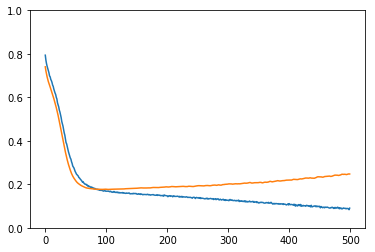

In [29]:
plt.ylim(0., 1.)
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Valid loss")

In [30]:
db_therapeutic_model.load_weights('db_therapeutic_model.h5')

In [31]:
pred = db_therapeutic_model.predict(X_valid)
pred_nn_t = np.copy(pred)

In [32]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

[0.083 0.016 0.019 0.034 0.024 0.085 0.019 0.01  0.059 0.015 0.037]


In [33]:
pred = db_therapeutic_model.predict(X_test)
pred_nn = np.copy(pred)
nn_auc_score = roc_auc_score(y_test,pred)
print(nn_auc_score)

0.5427018265962222


In [34]:
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
nn_f1_score = f1_score(y_test,pred,average='macro')
print(nn_f1_score)
print(f1_score(y_test,pred,average=None))

0.08064268864539494
[0.22807018 0.03418803 0.10606061 0.13913043 0.08333333 0.20512821
 0.03846154 0.016      0.         0.03669725 0.        ]


## Gradient Boosting of Keras Model with SVC

In [35]:
inp = db_therapeutic_model.input
out = db_therapeutic_model.layers[-2].output
db_therapeutic_model_gb = Model(inp, out)

In [36]:
X_train = db_therapeutic_model_gb.predict(X_train)
X_test = db_therapeutic_model_gb.predict(X_test)
X_valid = db_therapeutic_model_gb.predict(X_valid)

In [37]:
data = np.concatenate((X_train,X_test,X_valid),axis=0)

In [38]:
db_therapeutic_scaler2 = StandardScaler()
db_therapeutic_scaler2.fit(data)
X_train = db_therapeutic_scaler2.transform(X_train)
X_test = db_therapeutic_scaler2.transform(X_test)
X_valid = db_therapeutic_scaler2.transform(X_valid)

In [39]:
data = np.concatenate((X_train,X_test,X_valid),axis=0)

In [40]:
nca = NCA2

In [41]:
db_therapeutic_transformer2 = KernelPCA(n_components=nca, kernel='rbf', n_jobs=-1)
db_therapeutic_transformer2.fit(data)
X_train = db_therapeutic_transformer2.transform(X_train)
X_test = db_therapeutic_transformer2.transform(X_test)
X_valid = db_therapeutic_transformer2.transform(X_valid)

In [42]:
nca = X_train.shape[1]
parameters = {'estimator__class_weight':['balanced'],
              'estimator__kernel':['rbf','sigmoid'], 
              'estimator__C':[1,0.5,0.25], 'estimator__gamma':['scale','auto']}

db_therapeutic_svc_gb = GridSearchCV(OneVsRestClassifier(SVC(probability=True,
                                                             random_state=23)), 
                                     parameters, cv=3, scoring='roc_auc',n_jobs=-1)

In [43]:
result = db_therapeutic_svc_gb.fit(X_train, y_train)

In [44]:
pred = db_therapeutic_svc_gb.predict_proba(X_valid)
pred_svc_gb_t = np.copy(pred)
roc_auc_score(y_valid,pred)

0.4707440150819331

In [45]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

[0.1   0.021 0.061 0.05  0.049 0.13  0.008 0.007 0.015 0.017 0.018]


In [46]:
pred = db_therapeutic_svc_gb.predict(X_test)
f1_score(y_test,pred,average='macro')

0.08667464279544508

In [47]:
pred = db_therapeutic_svc_gb.predict_proba(X_test)
pred_svc_gb = np.copy(pred)
svc_gb_auc_score = roc_auc_score(y_test,pred)
print(svc_gb_auc_score)

0.4549157316755456


In [48]:
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
svc_gb_f1_score = f1_score(y_test,pred,average='macro')
print(svc_gb_f1_score)
print(f1_score(y_test,pred,average=None))

0.0872225463398049
[0.23140496 0.08       0.11111111 0.13084112 0.11764706 0.2
 0.         0.         0.05454545 0.03389831 0.        ]


## Gradient Boosting of Keras Model with XGBoost

In [49]:
parameters = {'estimator__learning_rate':[0.05,0.1,0.15],'estimator__n_estimators':[75,100,125], 'estimator__max_depth':[3,5,7],
              'estimator__booster':['gbtree','dart'],'estimator__reg_alpha':[0.1,0.05],'estimator__reg_lambda':[0.5,1.]}

db_therapeutic_xgb_gb = GridSearchCV(OneVsRestClassifier(XGBClassifier(random_state=32)), parameters, cv=3, scoring='roc_auc',n_jobs=-1)

In [50]:
result = db_therapeutic_xgb_gb.fit(X_train, y_train)

In [51]:
pred = db_therapeutic_xgb_gb.predict_proba(X_valid)
pred_xgb_gb_t = np.copy(pred)
roc_auc_score(y_valid,pred)

0.5114600994842798

In [52]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

[0.028 0.021 0.135 0.    0.018 0.063 0.    0.014 0.039 0.024 0.021]


In [53]:
pred = db_therapeutic_xgb_gb.predict(X_test)
f1_score(y_test,pred,average='macro')

0.008264462809917354

In [54]:
pred = db_therapeutic_xgb_gb.predict_proba(X_test)
pred_xgb_gb = np.copy(pred)
xgb_gb_auc_score = roc_auc_score(y_test,pred)
print(xgb_gb_auc_score)

0.5769233829467264


In [55]:
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
xgb_gb_f1_score = f1_score(y_test,pred,average='macro')
print(xgb_gb_f1_score)
print(f1_score(y_test,pred,average=None))

0.07675496321657999
[0.24460432 0.04081633 0.125      0.12030075 0.07017544 0.07017544
 0.01587302 0.02857143 0.08333333 0.04545455 0.        ]


In [56]:
pred = (pred_svc_t+pred_nn_t+pred_svc_gb_t+pred_xgb_gb_t)/4.

In [57]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

[0.075 0.019 0.081 0.043 0.028 0.089 0.011 0.    0.036 0.024 0.021]


In [58]:
pred = (pred_svc+pred_nn+pred_svc_gb+pred_xgb_gb)/4.
ave_auc_score = roc_auc_score(y_test,pred)
print(ave_auc_score)
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
ave_f1_score = f1_score(y_test,pred,average='macro')
print(ave_f1_score)
print(f1_score(y_test,pred,average=None))

0.5469775837395453
0.07816157187006557
[0.23943662 0.04597701 0.10526316 0.11570248 0.08064516 0.18604651
 0.02083333 0.01587302 0.         0.05       0.        ]


## Saving models, transformer and scaler

In [59]:
with open('db_therapeutic_svc.pkl', 'wb') as fid:
    pickle.dump(db_therapeutic_svc, fid)
with open('db_therapeutic_transformer1.pkl', 'wb') as fid:
    pickle.dump(db_therapeutic_transformer1, fid)
with open('db_therapeutic_transformer2.pkl', 'wb') as fid:
    pickle.dump(db_therapeutic_transformer2, fid)
with open('db_therapeutic_scaler1.pkl', 'wb') as fid:
    pickle.dump(db_therapeutic_scaler1, fid)
with open('db_therapeutic_scaler2.pkl', 'wb') as fid:
    pickle.dump(db_therapeutic_scaler2, fid)
with open('db_therapeutic_svc_gb.pkl', 'wb') as fid:
    pickle.dump(db_therapeutic_svc_gb, fid)
with open('db_therapeutic_xgb_gb.pkl', 'wb') as fid:
    pickle.dump(db_therapeutic_xgb_gb, fid)

## For loading saved model

```python
with open('db_therapeutic_svc.pkl', 'rb') as fid:
    db_therapeutic_svc = pickle.load(fid)
 ```

## F1 Score

[(0.0, 0.09158367365679515)]

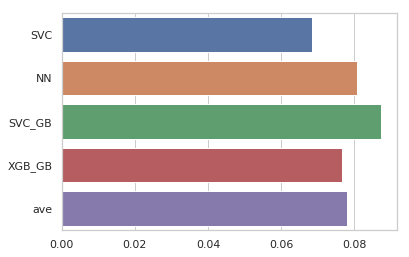

In [60]:
sns.set(style="whitegrid")
ax = sns.barplot(x=[svc_f1_score,nn_f1_score,svc_gb_f1_score,xgb_gb_f1_score,ave_f1_score],
                 y=['SVC','NN','SVC_GB','XGB_GB','ave'])
ax.set(xlim=(0.00, None))

## ROC-AUC

[(0.3, 0.6057695520940627)]

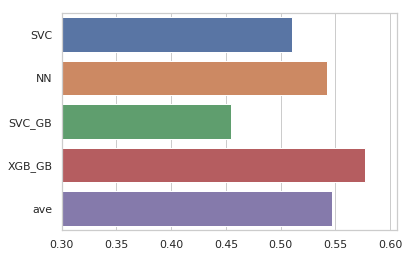

In [61]:
sns.set(style="whitegrid")
ax = sns.barplot(x=[svc_auc_score,nn_auc_score,svc_gb_auc_score,xgb_gb_auc_score,ave_auc_score],
                 y=['SVC','NN','SVC_GB','XGB_GB','ave'])
ax.set(xlim=(0.30, None))